# Testing models

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm
from zipfile import ZipFile
from sklearn.model_selection import train_test_spchi
from sklearn.metrics import RocCurveDisplay, auc, roc_curve

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# read in data
zip_file = ZipFile("data/adult23csv.zip")

df_full = pd.read_csv(zip_file.open('adult23.csv'))
y_name = 'LONGCOVD1_A'

In [9]:
chi_feats = ['SEX_A', 'URBRRL', 'MARITAL_A', 
                   'ANXEV_A', 'SHTCVD191_A', 'HISPALLP_A', 
                   'DEPEV_A', 'SMKCIGST_A', 'RATCAT_A', 
                   'MEDRXTRT_A', 'EDUCP_A', 'ARTHEV_A']
df_full.loc[:, chi_feats].isna().sum()

SEX_A          0
URBRRL         0
MARITAL_A      0
ANXEV_A        0
SHTCVD191_A    0
HISPALLP_A     0
DEPEV_A        0
SMKCIGST_A     0
RATCAT_A       0
MEDRXTRT_A     0
EDUCP_A        0
ARTHEV_A       0
dtype: int64

In [12]:
## PREPROCESSING CHI FEATURES
def preprocess_chi_features(df_full):
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    
    chi_feats = ['SEX_A', 'URBRRL', 'MARITAL_A', 
                   'ANXEV_A', 'SHTCVD191_A', 'HISPALLP_A', 
                   'DEPEV_A', 'SMKCIGST_A', 'RATCAT_A', 
                   'MEDRXTRT_A', 'EDUCP_A', 'ARTHEV_A']
    df_chi = df_full[chi_feats]
    df_chi[y_name] = df_full[y_name]
    df_chi = df_chi.dropna(subset=y_name)
    df_chi = df_chi[df_chi[y_name] != 9]

    # edit EDUCP_A
    df_chi['EDUCP_A'][df_chi['EDUCP_A'] > 10] = 0
    
    encoder = OneHotEncoder(drop='first', sparse_output=False).set_output(transform="pandas")
    scaler = StandardScaler().set_output(transform="pandas")
    
    X = df_chi.drop(columns=y_name)
    
    # define continuous and categorical features
    continuous = ['RATCAT_A', 'EDUCP_A']
    categorical = X.columns[~X.columns.isin(continuous)]
    
    # scale and encode
    cont_df =  scaler.fit_transform(X.loc[:, continuous])
    cat_df = encoder.fit_transform(X.loc[:,categorical])
    
    processed_df = pd.concat((cont_df, cat_df), axis=1)
    ## END PREPROCESSING
    
    X = processed_df.copy()
    y = df_chi.loc[:, y_name]
    y = (y == 1) * 1 # encode as 0 / 1 values
    
    # train test spchi
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=207)
    return X_train, X_test, y_train, y_test

In [13]:
X_train, X_test, y_train, y_test = preprocess_chi_features(df_full)

/var/folders/4b/qn1lg6_d6gj25p55qpkg8lhw0000gn/T/ipykernel_34452/2940709625.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chi[y_name] = df_full[y_name]
/var/folders/4b/qn1lg6_d6gj25p55qpkg8lhw0000gn/T/ipykernel_34452/2940709625.py:15: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = 

In [14]:
X_train

,RATCAT_A,EDUCP_A,SEX_A_2,SEX_A_7,SEX_A_9,URBRRL_2,URBRRL_3,URBRRL_4,MARITAL_A_2,MARITAL_A_3,...,SMKCIGST_A_3,SMKCIGST_A_4,SMKCIGST_A_5,SMKCIGST_A_9,MEDRXTRT_A_2,MEDRXTRT_A_7,MEDRXTRT_A_9,ARTHEV_A_2,ARTHEV_A_7,ARTHEV_A_9
4006,0.975491,0.757990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7701,-1.570072,-0.905807,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
24142,-0.551847,0.342041,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
17695,0.466379,0.757990,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
11763,0.466379,0.757990,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4515,0.975491,0.342041,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
16749,0.720935,1.173939,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6687,-0.042734,0.757990,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4685,0.211822,0.757990,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [17]:
coords = {"coeffs":X_train.columns}

with pm.Model(coords=coords) as hier_chi_model:
    # data containers
    X = pm.Data("X", X_train.values)
    y = pm.Data("y", y_train)

    mu = 0

    # No shrinkage on intercept
    b0 = pm.Normal("beta0", 0, 100)

    mu += b0 # add intercept

    # Loop through each feature prefix
    for prefix in set(chi_feats):
        # Identify column indices matching the prefix
        cols_in_group = [i for i, col in enumerate(X_train.columns) if col.startswith(prefix)]

        X_group = X[:, cols_in_group]

        # Define shared hyperpriors for the group
        group_mu = pm.Normal(f"{prefix}_mu", mu=0, sigma=1)
        group_sigma = pm.HalfNormal(f"{prefix}_sigma", sigma=2) ## INCREASED SIGMA

        # Group-level coefficients
        group_b = pm.Normal(f"b_{prefix}", mu=group_mu, sigma=group_sigma, shape=len(cols_in_group))

        mu += pm.math.dot(X_group, group_b)

    # link function
    p = pm.Deterministic("p", pm.math.invlogit(mu))
    # likelihood
    pm.Bernoulli("obs", p=p, observed=y)
hier_chi_model

            beta0 ~ Normal(0, 100)
       ANXEV_A_mu ~ Normal(0, 1)
    ANXEV_A_sigma ~ HalfNormal(0, 2)
        b_ANXEV_A ~ Normal(ANXEV_A_mu, ANXEV_A_sigma)
    MEDRXTRT_A_mu ~ Normal(0, 1)
 MEDRXTRT_A_sigma ~ HalfNormal(0, 2)
     b_MEDRXTRT_A ~ Normal(MEDRXTRT_A_mu, MEDRXTRT_A_sigma)
      ARTHEV_A_mu ~ Normal(0, 1)
   ARTHEV_A_sigma ~ HalfNormal(0, 2)
       b_ARTHEV_A ~ Normal(ARTHEV_A_mu, ARTHEV_A_sigma)
       EDUCP_A_mu ~ Normal(0, 1)
    EDUCP_A_sigma ~ HalfNormal(0, 2)
        b_EDUCP_A ~ Normal(EDUCP_A_mu, EDUCP_A_sigma)
       DEPEV_A_mu ~ Normal(0, 1)
    DEPEV_A_sigma ~ HalfNormal(0, 2)
        b_DEPEV_A ~ Normal(DEPEV_A_mu, DEPEV_A_sigma)
      RATCAT_A_mu ~ Normal(0, 1)
   RATCAT_A_sigma ~ HalfNormal(0, 2)
       b_RATCAT_A ~ Normal(RATCAT_A_mu, RATCAT_A_sigma)
         SEX_A_mu ~ Normal(0, 1)
      SEX_A_sigma ~ HalfNormal(0, 2)
          b_SEX_A ~ Normal(SEX_A_mu, SEX_A_sigma)
   SHTCVD191_A_mu ~ Normal(0, 1)
SHTCVD191_A_sigma ~ HalfNormal(0, 2)
    b_SHTCVD191_A ~ N

In [18]:
with hier_chi_model:
    idata_hier_chi = pm.sample_smc()

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


/Users/katherinehunter/Active_projects/AM207_project/.venv/lib/python3.11/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (12297), generating only 20 plots
  warnings.warn(


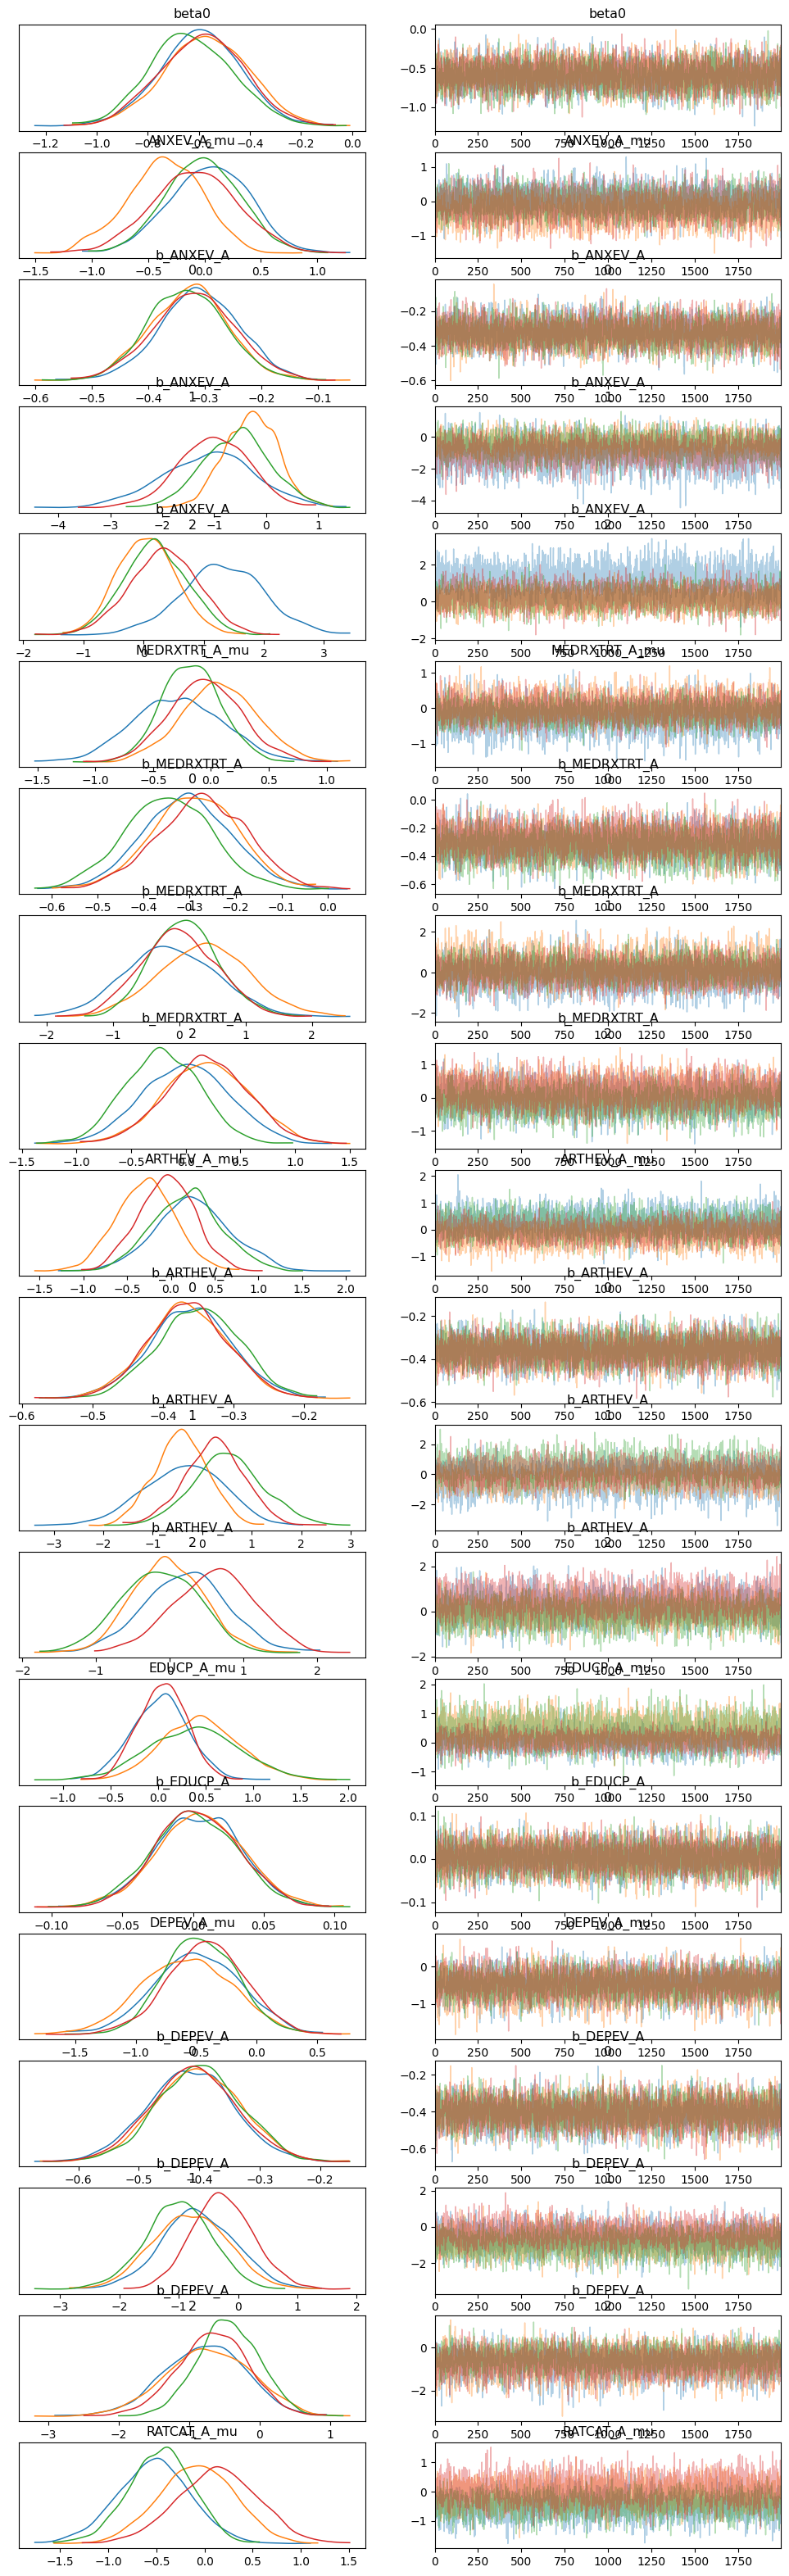

In [19]:
az.plot_trace(idata_hier_chi, compact=False);

In [20]:
az.summary(idata_hier_chi, var_names='b_', filter_vars="like")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_ANXEV_A[0],-0.322,0.071,-0.458,-0.193,0.001,0.001,3766.0,6776.0,1.01
b_ANXEV_A[1],-0.743,0.773,-2.263,0.626,0.168,0.121,22.0,91.0,1.12
b_ANXEV_A[2],0.476,0.758,-0.782,2.024,0.254,0.186,10.0,29.0,1.30
b_MEDRXTRT_A[0],-0.304,0.100,-0.492,-0.118,0.013,0.009,58.0,5629.0,1.05
b_MEDRXTRT_A[1],0.086,0.639,-1.077,1.301,0.089,0.063,53.0,176.0,1.05
b_MEDRXTRT_A[2],0.040,0.413,-0.725,0.809,0.085,0.061,24.0,252.0,1.11
b_ARTHEV_A[0],-0.360,0.058,-0.471,-0.255,0.001,0.000,7250.0,7363.0,1.01
b_ARTHEV_A[1],-0.014,0.788,-1.573,1.406,0.209,0.151,14.0,73.0,1.19
b_ARTHEV_A[2],0.163,0.604,-0.937,1.315,0.145,0.105,18.0,70.0,1.15
b_EDUCP_A[0],0.003,0.030,-0.055,0.057,0.000,0.000,7777.0,7753.0,1.00


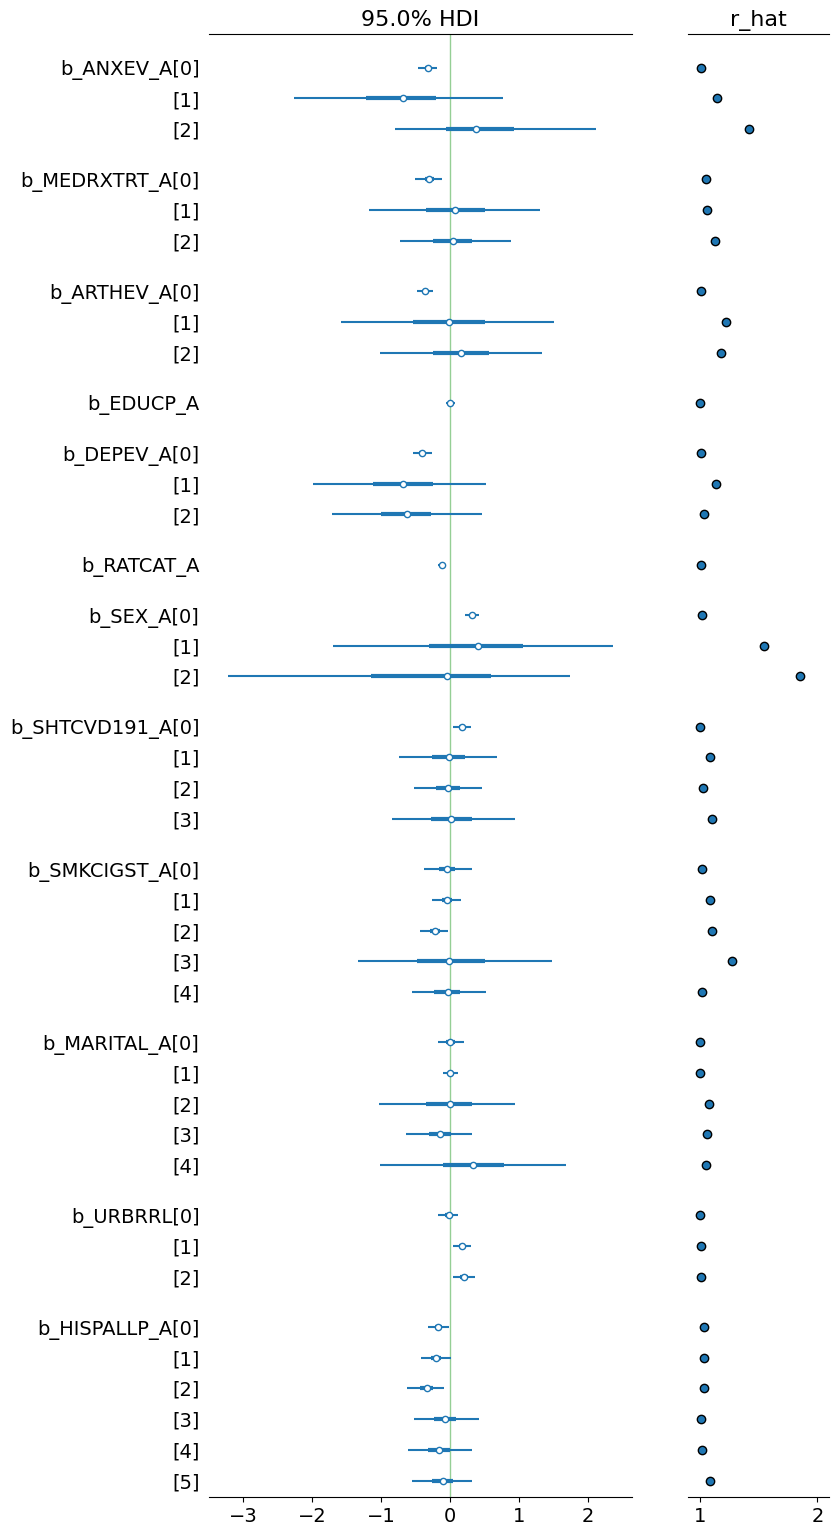

In [21]:
az.plot_forest(idata_hier_chi, var_names='b_', filter_vars="like", combined=True, hdi_prob=0.95, r_hat=True, rope=(0, 0));

In [23]:
def plot_roc(y_true, p_pred, title="ROC"):
    fpr, tpr, thresholds = roc_curve(
        y_true=y_true, y_score=p_pred, pos_label=1, drop_intermediate=False
    )
    roc_auc = auc(fpr, tpr)
    
    fig, ax = plt.subplots()
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    roc_display = roc_display.plot(ax=ax, marker="o", markersize=4)
    x = np.linspace(0,1)
    y = x
    plt.plot(x,y, linestyle='--')
    ax.set(title=title);

def get_preds(trace, y_true):
    p_pred = trace.predictions["obs"].mean(dim=["chain", "draw"])
    y_pred = (p_pred >= 0.5).astype("int").to_numpy()
    print(f"accuracy = {np.mean(y_true==y_pred): 0.3f}")

    return p_pred, y_pred

# p_train_pred, y_train_pred = get_preds(idata_hier_chi, y_train)
# plot_roc(y_train, p_train_pred, title="Simple model ROC")

In [25]:
with hier_chi_model:
    pm.set_data({"X": X_test.values, "y": y_test})
    idata_hier_chi.extend(pm.sample_posterior_predictive(idata_hier_chi))

Sampling: [obs]


Output()

accuracy =  0.843


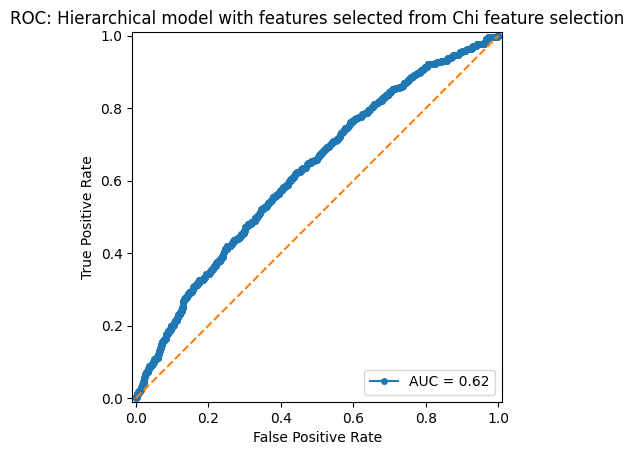

In [26]:
# ROC for Hier Ci model
p_test_pred = idata_hier_chi.posterior_predictive["obs"].mean(dim=["chain", "draw"])
y_test_pred = (p_test_pred >= 0.5).astype("int").to_numpy()
print(f"accuracy = {np.mean(y_test==y_test_pred): 0.3f}")
plot_roc(y_test, p_test_pred, title="ROC: Hierarchical model with features selected from Chi feature selection")